## Preprocessing


In [2]:
import numpy as np
import pandas as pd
from scipy.io.arff import loadarff

raw_data = loadarff("../data/credit_fraud.arff")
df = pd.DataFrame(raw_data[0])
df = df.map(lambda x: x.decode("utf-8") if type(x) == bytes else x)
df.head()

,over_draft,credit_usage,credit_history,purpose,current_balance,Average_Credit_Balance,employment,location,personal_status,other_parties,...,property_magnitude,cc_age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad


In [3]:
# Check if there are any null values
df.isna().sum().sum()

0

In [4]:
from sklearn.model_selection import train_test_split

# replace label values by 1 and 0
df["class"] = df["class"].replace({"good": 0, "bad": 1})

# Divide datasets to features and labels
X = df.drop("class", axis=1)
y = df[["class"]]

# Stratified training_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=df["class"]
)

# Demonstrate stratified sampling
print("Label Distributions")
datasets = {"full_dataset": y, "training_split": y_train, "testing_split": y_test}
for name, dataset in datasets.items():
    label_proportion = dataset["class"].value_counts(normalize=True)
    print(f"{name}: good {label_proportion.loc[0]} bad {label_proportion.loc[1]}")

Label Distributions
full_dataset: good 0.7 bad 0.3
training_split: good 0.7 bad 0.3
testing_split: good 0.7 bad 0.3


In [5]:
nominal_cat_columns = [
    "purpose",
    "other_parties",
    "property_magnitude",
    "other_payment_plans",
    "housing",
    "job",
    "own_telephone",
    "num_dependents",
    "foreign_worker",
]
unordered_ordinal_cat_columns = [
    "over_draft",
    "credit_history",
    "Average_Credit_Balance",
    "employment",
]
ordered_ordinal_cat_columns = ["existing_credits", "residence_since", "location"]
needs_cleaning = ["personal_status"]
num_columns = ["credit_usage", "current_balance", "cc_age"]

over_draft_categories = ["no checking", "<0", "0<=X<200", ">=200"]
credit_history_categories = [
    "no credits/all paid",
    "all paid",
    "existing paid",
    "delayed previously",
    "critical/other existing credit",
]
average_credit_balance_categories = [
    "no known savings",
    "<100",
    "100<=X<500",
    "500<=X<1000",
    ">=1000",
]
employment_categories = ["unemployed", "<1", "1<=X<4", "4<=X<7", ">=7"]

In [6]:
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    FunctionTransformer,
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_pipe = Pipeline([("standard_scaler", StandardScaler())])
nominal_cat_pipe = Pipeline(
    [("onehot_encoding", OneHotEncoder(drop="if_binary", handle_unknown="ignore"))]
)
ordered_ordinal_cat_pipe = Pipeline(
    [
        (
            "ordinal_encoding",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
        )
    ]
)
over_draft_pipe = Pipeline(
    [("ordinal_encoding", OrdinalEncoder(categories=[over_draft_categories]))]
)
credit_history_pipe = Pipeline(
    [("ordinal_encoding", OrdinalEncoder(categories=[credit_history_categories]))]
)
average_credit_bal_pipe = Pipeline(
    [
        (
            "ordinal_encoding",
            OrdinalEncoder(categories=[average_credit_balance_categories]),
        )
    ]
)
employment_pipe = Pipeline(
    [("ordinal_encoding", OrdinalEncoder(categories=[employment_categories]))]
)


def split_personal_status(X: pd.DataFrame):
    personal_status = X["personal_status"]
    temp_df = personal_status.str.split(" ", expand=True)
    df = pd.DataFrame()
    df["is_male"] = (temp_df == "male")[0].astype("int")
    df["is_single"] = (temp_df == "single")[1].astype("int")
    return df


personal_status_pipe = Pipeline(
    [
        (
            "split_personal_status",
            FunctionTransformer(
                split_personal_status,
                feature_names_out=lambda x, y: ["is_male", "is_single"],
            ),
        )
    ]
)

In [7]:
preprocessing = ColumnTransformer(
    [
        ("num", num_pipe, num_columns),
        ("nominal_cat", nominal_cat_pipe, nominal_cat_columns),
        ("ordinal_cat", ordered_ordinal_cat_pipe, ordered_ordinal_cat_columns),
        ("over_draft", over_draft_pipe, ["over_draft"]),
        ("credit_history", credit_history_pipe, ["credit_history"]),
        ("average_credit_bal", average_credit_bal_pipe, ["Average_Credit_Balance"]),
        ("employment", employment_pipe, ["employment"]),
        ("personal_status", personal_status_pipe, ["personal_status"]),
    ]
)

## Model Selection


In [23]:
# dictionary to store the cross validation scores (roc_auc) of all the models
cv_scores = {}

{'a': 1}

In [25]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix

# Define model
dummy_clf = Pipeline(
    [("preprocessing", preprocessing), ("dummy_clf", DummyClassifier())]
)

# Compute cv accuracy
cv_score = cross_val_score(
    dummy_clf, X_train, y_train.values.ravel(), scoring="roc_auc", cv=10
)
print(f"Cross validation roc_auc: {cv_score.mean()}")
cv_scores["Dummy"] = cv_score

# Confusion matrix
y_train_pred = cross_val_predict(dummy_clf, X_train, y_train.values.ravel(), cv=10)
cm = confusion_matrix(y_train, y_train_pred)
print(f"Confusion matrix:\n {cm}")

Cross validation roc_auc: 0.5
Confusion matrix:
 [[560   0]
 [240   0]]


In [24]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix

# Define model
sgd_model = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("sdg_clf", SGDClassifier(random_state=42)),
    ]
)

# Compute cv accuracy
cv_score = cross_val_score(
    sgd_model, X_train, y_train.values.ravel(), scoring="roc_auc", cv=10
)
print(f"Roc auc: {cv_score.mean()}")
cv_scores["Stochastic Gradient Descent"] = cv_score

# Confusion matrix
y_train_pred = cross_val_predict(sgd_model, X_train, y_train.values.ravel(), cv=10)
cm = confusion_matrix(y_train, y_train_pred)
print(f"Confusion matrix:\n {cm}")

Roc auc: 0.712202380952381
Confusion matrix:
 [[463  97]
 [147  93]]


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

forest_model = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("forest_clf", RandomForestClassifier(random_state=42)),
    ]
)

# Accuracy
cv_score = cross_val_score(
    forest_model, X_train, y_train.values.ravel(), scoring="roc_auc", cv=10
)
print(f"Roc auc: {cv_score.mean()}")
cv_scores["Random Forest"] = cv_score

# Recall
cv_score = cross_val_score(
    forest_model, X_train, y_train.values.ravel(), scoring="recall", cv=10
)
print(f"Recall: {cv_score.mean()}")

# Confusion matrix
y_train_pred = cross_val_predict(forest_model, X_train, y_train.values.ravel(), cv=10)
cm = confusion_matrix(y_train, y_train_pred)
print(f"Confusion matrix:\n {cm}")

Roc auc: 0.7899181547619047
Recall: 0.35416666666666663
Confusion matrix:
 [[523  37]
 [155  85]]


In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

knn_clf = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("knn_clf", KNeighborsClassifier()),
    ]
)

# Accuracy
cv_score = cross_val_score(
    knn_clf, X_train, y_train.values.ravel(), scoring="roc_auc", cv=10
)
print(f"Roc auc: {cv_score.mean()}")
cv_scores["Knn"] = cv_score

# Confusion matrix
y_train_pred = cross_val_predict(knn_clf, X_train, y_train.values.ravel(), cv=10)
cm = confusion_matrix(y_train, y_train_pred)
print(f"Confusion matrix:\n {cm}")

Roc auc: 0.7225446428571429
Confusion matrix:
 [[496  64]
 [144  96]]


In [28]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

gbooster_clf = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("gbooster_clf", GradientBoostingClassifier(random_state=42)),
    ]
)

# Accuracy
cv_score = cross_val_score(
    gbooster_clf, X_train, y_train.values.ravel(), scoring="roc_auc", cv=10
)
print(f"Roc auc: {cv_score.mean()}")
cv_scores["Gradient Booster"] = cv_score

# Confusion matrix
y_train_pred = cross_val_predict(gbooster_clf, X_train, y_train.values.ravel(), cv=10)
cm = confusion_matrix(y_train, y_train_pred)
print(f"Confusion matrix:\n {cm}")

Roc auc: 0.7777529761904762
Confusion matrix:
 [[489  71]
 [125 115]]


In [29]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier

bbc = BalancedBaggingClassifier(
    estimator=DecisionTreeClassifier(),
    sampling_strategy="majority",
    replacement=False,
    random_state=42,
)

bbc_tree_clf = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("bbc_tree_clf", bbc),
    ]
)

# Accuracy
cv_score = cross_val_score(
    bbc_tree_clf, X_train, y_train.values.ravel(), scoring="roc_auc", cv=10
)
print(f"Roc auc: {round(cv_score.mean(),3)}")
cv_scores["Balanced Bagging"] = cv_score

# Confusion matrix
y_train_pred = cross_val_predict(bbc_tree_clf, X_train, y_train.values.ravel(), cv=10)
cm = confusion_matrix(y_train, y_train_pred)
print(f"Confusion matrix:\n {cm}")

Roc auc: 0.755
Confusion matrix:
 [[433 127]
 [106 134]]


In [30]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from imblearn.ensemble import BalancedRandomForestClassifier

brf = BalancedRandomForestClassifier(
    sampling_strategy="majority", replacement=True, random_state=42
)
brf_model = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("brf_clf", brf),
    ]
)

# Roc auc
cv_score = cross_val_score(
    brf_model, X_train, y_train.values.ravel(), scoring="roc_auc", cv=10
)
print(f"Roc auc: {round(cv_score.mean(),3)}")
cv_scores["Balanced Random Forest"] = cv_score

# Recall
cv_score = cross_val_score(
    brf_model, X_train, y_train.values.ravel(), scoring="recall", cv=10
)
print(f"Recall {round(cv_score.mean(),3)}")

# Confusion matrix
y_train_pred = cross_val_predict(brf_model, X_train, y_train.values.ravel(), cv=10)
cm = confusion_matrix(y_train, y_train_pred)
print(f"Confusion matrix:\n {cm}")

Roc auc: 0.795
Recall 0.787
Confusion matrix:
 [[358 202]
 [ 51 189]]


In [31]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from imblearn.ensemble import RUSBoostClassifier

rb = RUSBoostClassifier(sampling_strategy="majority", replacement=True, random_state=42)
rb_clf = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("rb_clf", rb),
    ]
)

# Roc auc
cv_score = cross_val_score(
    rb_clf, X_train, y_train.values.ravel(), scoring="roc_auc", cv=10
)
print(f"Roc auc: {round(cv_score.mean(),3)}")
cv_scores["RUS Booster"] = cv_score

# Recall
cv_score = cross_val_score(
    rb_clf, X_train, y_train.values.ravel(), scoring="recall", cv=10
)
print(f"Recall {round(cv_score.mean(),3)}")

# Confusion matrix
y_train_pred = cross_val_predict(rb_clf, X_train, y_train.values.ravel(), cv=10)
cm = confusion_matrix(y_train, y_train_pred)
print(f"Confusion matrix:\n {cm}")

Roc auc: 0.728
Recall 0.646
Confusion matrix:
 [[382 178]
 [ 85 155]]


Text(0, 0.5, 'ROC area under curve')

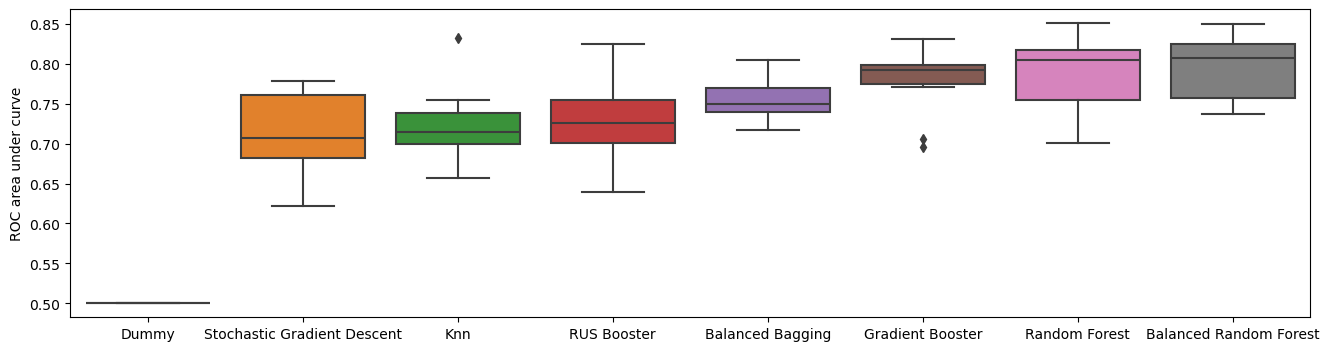

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(cv_scores)

ordered_models = sorted(cv_scores.keys(), key=lambda x: cv_scores[x].mean())
fig, axis = plt.subplots(
    1,
    1,
    figsize=(16, 4),
)
sns.boxplot(data=df, ax=axis, order=ordered_models)
axis.set_ylabel("ROC area under curve")

## Hyperparameter Tuning


In [16]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [100, 200, 300]  # number of trees in the random forest
max_features = ["log2"]  # number of features in consideration at every split
max_depth = [5, 6, 7]  # maximum number of levels allowed in each decision tree
min_samples_split = [5, 6, 7]  # minimum sample number to split a node
min_samples_leaf = [3, 5, 7]  # minimum sample number that can be stored in a leaf node
bootstrap = [True]  # method used to sample data points

random_grid = {
    "brf_clf__n_estimators": n_estimators,
    "brf_clf__max_features": max_features,
    "brf_clf__max_depth": max_depth,
    "brf_clf__min_samples_split": min_samples_split,
    # "brf_clf__min_samples_leaf": min_samples_leaf,
    # "brf_clf__bootstrap": bootstrap,
}

rnd_search = RandomizedSearchCV(
    estimator=brf_model,
    param_distributions=random_grid,
    n_iter=100,
    cv=10,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring="roc_auc",
)

rnd_search.fit(X_train, y_train.values.ravel())

print("\nBest Parameters: ", rnd_search.best_params_, " \n")
print("\nBest score (roc_auc)", rnd_search.best_score_)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


/home/perezs/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=100. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END brf_clf__max_depth=5, brf_clf__max_features=log2, brf_clf__min_samples_split=5, brf_clf__n_estimators=100; total time=   0.5s
[CV] END brf_clf__max_depth=5, brf_clf__max_features=log2, brf_clf__min_samples_split=5, brf_clf__n_estimators=100; total time=   0.5s
[CV] END brf_clf__max_depth=5, brf_clf__max_features=log2, brf_clf__min_samples_split=5, brf_clf__n_estimators=100; total time=   0.5s
[CV] END brf_clf__max_depth=5, brf_clf__max_features=log2, brf_clf__min_samples_split=5, brf_clf__n_estimators=100; total time=   0.5s
[CV] END brf_clf__max_depth=5, brf_clf__max_features=log2, brf_clf__min_samples_split=5, brf_clf__n_estimators=100; total time=   0.5s
[CV] END brf_clf__max_depth=5, brf_clf__max_features=log2, brf_clf__min_samples_split=5, brf_clf__n_estimators=100; total time=   0.5s
[CV] END brf_clf__max_depth=5, brf_clf__max_features=log2, brf_clf__min_samples_split=5, brf_clf__n_estimators=100; total time=   0.6s
[CV] END brf_clf__max_depth=5, brf_clf__max_features=lo

## Final model


In [17]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, recall_score
from imblearn.ensemble import BalancedRandomForestClassifier

brf = BalancedRandomForestClassifier(
    sampling_strategy="majority",
    replacement=True,
    random_state=42,
    n_estimators=200,
    max_depth=6,
    max_features="log2",
    min_samples_split=6,
)

final_model = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("brf_clf", brf),
    ]
)


# Roc auc
print("-" * 10 + "CROSS VALIDATION" + "-" * 10)
cv_score = cross_val_score(
    final_model, X_train, y_train.values.ravel(), scoring="roc_auc", cv=10
)
print(f"Roc auc: {round(cv_score.mean(),3)}")

# Recall
cv_score = cross_val_score(
    final_model, X_train, y_train.values.ravel(), scoring="recall", cv=10
)
print(f"Recall {round(cv_score.mean(),3)}")

# Confusion matrix
y_train_pred = cross_val_predict(final_model, X_train, y_train.values.ravel(), cv=10)
cm = confusion_matrix(y_train, y_train_pred)
print(f"Confusion matrix:\n {cm}")

# Fit to whole training set, predict test set
print("-" * 10 + "TEST" + "-" * 10)
final_model.fit(X_train, y_train.values.ravel())
y_test_predicted = final_model.predict(X_test)
y_test_proba = final_model.predict_proba(X_test)[:, 1]

# roc
score = roc_auc_score(y_test, y_test_proba)
print(f"test roc_auc: {round(score,3)}")

# recall
score = recall_score(y_test, y_test_predicted)
print(f"test recall: {round(score,3)}")

# Confusion matrix
cm = confusion_matrix(y_test, y_test_predicted)
print(f"Confusion matrix:\n {cm}")

----------CROSS VALIDATION----------
Roc auc: 0.8
Recall 0.796
Confusion matrix:
 [[356 204]
 [ 49 191]]
----------TEST----------
test roc_auc: 0.792
test recall: 0.8
Confusion matrix:
 [[89 51]
 [12 48]]


In [20]:
final_model.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['credit_usage',
                                                   'current_balance',
                                                   'cc_age']),
                                                 ('nominal_cat',
                                                  Pipeline(steps=[('onehot_encoding',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['purpose', 'other_parties',
                                                   'property_magnitude',
                                                   'other_payment_plans'...
                                                  Pipeline(steps=[('split_personal_status',
                                                                   FunctionTransformer(feature_names_out=<function <lambda> at 0x7f5d84ca3380>,
                                                                                       func=<function split_personal_status at 0x7f5d84ca00e0>))]),
                                                  ['personal_status'])])),
                ('brf_clf',
                 BalancedRandomForestClassifier(max_depth=6,
                                                max_features='log2',
                                                min_samples_split=6,
                                                n_estimators=200,
                                                random_state=42,
                                                replacement=True,
                                                sampling_strategy='majority'))])

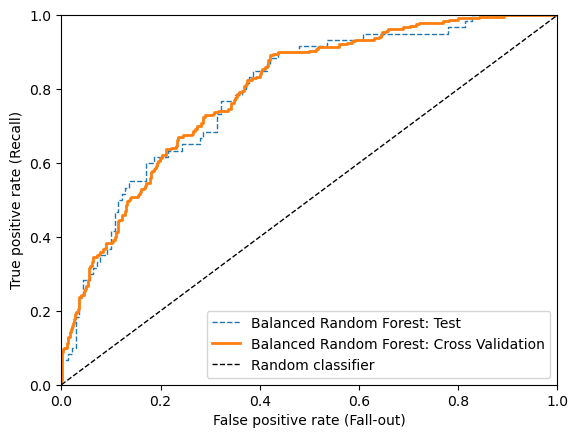

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Test
fpr, tpr, threshold = roc_curve(y_test, y_test_proba)
plt.plot(fpr, tpr, "--", linewidth=1, label="Balanced Random Forest: Test")

# Cross validation
y_train_proba = cross_val_predict(
    final_model, X_train, y_train.values.ravel(), cv=10, method="predict_proba"
)[:, 1]
fpr, tpr, threshold = roc_curve(y_train, y_train_proba)
plt.plot(fpr, tpr, linewidth=2, label="Balanced Random Forest: Cross Validation")

plt.plot(
    np.linspace(0, 1, 100),
    np.linspace(0, 1, 100),
    "k--",
    linewidth=1,
    label="Random classifier",
)
plt.xlabel("False positive rate (Fall-out)")
plt.ylabel("True positive rate (Recall)")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()

In [19]:
# FEatures importance
final_model.fit(X_train, y_train.values.ravel())
features = final_model["preprocessing"].get_feature_names_out()
importance = final_model["brf_clf"].feature_importances_
features_importance = pd.DataFrame({"feature": features, "importance": importance})
features_importance.sort_values(by="importance", ascending=False).head()

,feature,importance
36,over_draft__over_draft,0.163286
1,num__current_balance,0.091212
0,num__credit_usage,0.090240
2,num__cc_age,0.064894
37,credit_history__credit_history,0.056059
